## Brian and Bianca - Grid World MDP

In this tutorial, we try to provide a simple example of how to define a Markov decision process (MDP) problem using the [POMDPs.jl](https://github.com/sisl/POMDPs.jl) interface. After defining the problem in this way, you will be able to use the solvers that the interface supports. In this tutorial, we will show you how to use the value iteration and the Monte Carlo Tree Search solvers that the POMDPs.jl interface supports. We assume that you have some knowledge of basic programming, but are not necessarily familiar with all the features that exist in Julia. We try to cover the many language specific features used in POMDPs.jl in this tutorial. We do assume that you know the grid world problem, and are familiar with the formal defintion of the MDP.  Let's get started!

## Dependencies
You need to install a few modules in order to use this notebook. If you have all the modules below installed, great! If not run the following commands:


```julia
# install the POMDPs.jl interface
Pkg.add("POMDPs")
Pkg.add("POMDPModelTools")
Pkg.add("POMDPPolicies")
Pkg.add("POMDPSimulators")
```

If you already have all of the modules above, make sure you have the most recent versions. Many of these are still under heavy development, so update before starting by running

```julia
Pkg.update()
```

In [1]:
# first import the POMDPs.jl interface
using POMDPs

# POMDPModelTools has tools that help build the MDP definition
using POMDPModelTools
# POMDPPolicies provides functions to help define simple policies
using POMDPPolicies
# POMDPSimulators provide functions for running MDP simulations
using POMDPSimulators

using Debugger

using ColorSchemes, Colors

using Plots

## Problem Overview
In Grid World, we are trying to control an agent who has trouble moving in the desired direction. In our problem, we have a four reward states on a $10\times 10$ grid. Each position on the grid represents a state, and the positive reward states are terminal (the agent stops recieveing reward after reaching them). The agent has four actions to choose from: up, down, left, right. The agent moves in the desired direction with a probability of 0.7, and with a probability of 0.1 in each of the remaining three directions. The problem has the following form (checkout [this page](https://artint.info/2e/html/ArtInt2e.Ch9.S5.html) for more information):

![example](http://artint.info/figures/ch09/gridworldc.gif)

## MDP Type

In POMDPs.jl, an MDP is defined by creating a subtype of the `MDP` abstract type. The types of the states and actions for the MDP are declared as [parameters](https://docs.julialang.org/en/v1/manual/types/#Parametric-Types-1) of the `MDP` type.  For example, if our states and actions are both represented by integers we can define our MDP type in the following way:
```julia
type MyMDP <: MDP{Int64, Int64} # MDP{StateType, ActionType}

end
```
`MyMDP` is a subtype from an abstract MDP type defined in POMDPs.jl. Let's first define types to represent grid worls states and actions, and then we'll go through defining our Grid World MDP type. 

## States
The data container below represents the state of the agent in the grid world.

In [2]:
struct GridWorldState 
    x::Int64 # x position
    y::Int64 # y position
    done::Bool # are we in a terminal state?
end

Below are some convenience functions for working with the GridWorldState. 

In [3]:
# initial state constructor
GridWorldState(x::Int64, y::Int64) = GridWorldState(x,y,false)
# checks if the position of two states are the same
posequal(s1::GridWorldState, s2::GridWorldState) = s1.x == s2.x && s1.y == s2.y

posequal (generic function with 1 method)

## Actions
Since our action is simply the direction the agent chooses to go (i.e. up, down, left, right), we can use a Symbol to represent it. Symbols are essentially the same as strings, but they typically consist of only one word and literals begin with "`:`". See [this page](https://stackoverflow.com/questions/23480722/what-is-a-symbol-in-julia) for a technical discussion of what they are. Note that in this case, we will not define a custom type for our action, instead we represent it directly with a symbol. So that our action looks like:
```julia
action = :up # can also be :down, :left, :right
```

## MDP
The GridWorld data container is defined below. It holds all the information we need to define the MDP tuple $$(\mathcal{S}, \mathcal{A}, T, R).$$

In [4]:
# the grid world mdp type
mutable struct GridWorld <: MDP{GridWorldState, Symbol} # Note that our MDP is parametarized by the state and the action
    size_x::Int64 # x size of the grid
    size_y::Int64 # y size of the grid
    reward_states::Vector{GridWorldState} # the states in which agent recieves reward
    reward_values::Vector{Float64} # reward values for those states
    tprob::Float64 # probability of transitioning to the desired state
    discount_factor::Float64 # disocunt factor
end

Before moving on, I want to create a constructor for GridWorld for convenience. Currently, if I want to create an instance of GridWorld, I have to pass in all of fields inside the GridWorld container (size_x, size_y, etc). The function below will return a GridWorld type with all the fields filled with some default values.

In [77]:
#we use key worded arguments so we can change any of the values we pass in 
function GridWorld(;sx::Int64=5, # size_x
                    sy::Int64=5, # size_y
                    rs::Vector{GridWorldState}=[GridWorldState(5,5), GridWorldState(3,4), GridWorldState(1,3), GridWorldState(4,2)], # reward states
                    rv = [10., -10., -5., -3.], # reward values
                    tp::Float64=0.7, # tprob
                    discount_factor::Float64=0.9)
    return GridWorld(sx, sy, rs, rv, tp, discount_factor)
end

# we can now create a GridWorld mdp instance like this:
mdp = GridWorld()
mdp.reward_states # mdp contains all the defualt values from the constructor

4-element Vector{GridWorldState}:
 GridWorldState(5, 5, false)
 GridWorldState(3, 4, false)
 GridWorldState(1, 3, false)
 GridWorldState(4, 2, false)

## Spaces
Let's look at how we can define the state and action spaces for our problem.

### State Space
The state space in an MDP represents all the states in the problem. There are two primary functionalities that we want our spaces to support. We want to be able to iterate over the state space (for Value Iteration for example), and sometimes we want to be able to sample form the state space (used in some POMDP solvers). In this notebook, we will only look at iterable state spaces. 

Since we can iterate over elements of an array, and our problem is small, we can store all of our states in an array. If your problem is very large (tens of millions of states), it might be worthwhile to create a custom type to define the problem's state space. See [the documentation](https://docs.julialang.org/en/v1/manual/interfaces/) on which functions you need to implement in order to create your own iterator. 

In [78]:
function POMDPs.states(mdp::GridWorld)
    s = GridWorldState[] # initialize an array of GridWorldStates
    # loop over all our states, remeber there are two binary variables:
    # done (d)
    for d = 0:1, y = 1:mdp.size_y, x = 1:mdp.size_x
        push!(s, GridWorldState(x,y,d))
    end
    return s
end;

Here, the code: ```function POMDPs.states(mdp::GridWorld)``` means that we want to take the function called ```states(...)``` from the POMDPs.jl module and add another method to it. The ```states(...)``` function in POMDPs.jl doesn't know about our GridWorld type. However, now when ```states(...)``` is called with GridWorld it will dispatch the function we defined above! This is the awesome thing about multiple-dispatch, and one of the features that should make working with MDP/POMDPs easier in Julia. 

The solvers that support the POMDPs.jl interface know that a function called ```states(...)``` exists in the interface. However, they do not know the behavior of that function for GridWorld. That means in order for the solvers to use this behavior all we have to do is pass an instance of our GridWorld type into the solver. When ```states(...)``` is called in the solver with the GridWorld type, the function above will be called.   

In [79]:
mdp = GridWorld()
state_space = states(mdp)
state_space[1]
state_space

50-element Vector{GridWorldState}:
 GridWorldState(1, 1, false)
 GridWorldState(2, 1, false)
 GridWorldState(3, 1, false)
 GridWorldState(4, 1, false)
 GridWorldState(5, 1, false)
 GridWorldState(1, 2, false)
 GridWorldState(2, 2, false)
 GridWorldState(3, 2, false)
 GridWorldState(4, 2, false)
 GridWorldState(5, 2, false)
 GridWorldState(1, 3, false)
 GridWorldState(2, 3, false)
 GridWorldState(3, 3, false)
 ⋮
 GridWorldState(4, 3, true)
 GridWorldState(5, 3, true)
 GridWorldState(1, 4, true)
 GridWorldState(2, 4, true)
 GridWorldState(3, 4, true)
 GridWorldState(4, 4, true)
 GridWorldState(5, 4, true)
 GridWorldState(1, 5, true)
 GridWorldState(2, 5, true)
 GridWorldState(3, 5, true)
 GridWorldState(4, 5, true)
 GridWorldState(5, 5, true)

### Action Space

The action space is the set of all actions availiable to the agent. In the grid world problem the action space consists of up, down, left, and right. We can define the action space by implementing a new method of the `actions` function.

In [80]:
POMDPs.actions(mdp::GridWorld) = [:up, :down, :left, :right];
states(mdp)
reward


reward (generic function with 7 methods)

Now that we've defined our state and action spaces, we are half-way thorugh our MDP tuple:
$$
(\mathcal{S}, \mathcal{A}, T, R)
$$

## Reward Model
The reward model $R(s,a,s')$ is a function that returns the reward of being in state $s$, taking an action $a$ from that state, and ending up in state $s'$. In our problem, we are rewarded for reaching a terminal reward state (this could be positive or negative).

In [111]:
function POMDPs.reward(mdp::GridWorld, state::GridWorldState, action::Symbol, statep::GridWorldState) #deleted action
    if state.done
        return 0.0
    end
    r = 0.0
    n = length(mdp.reward_states)
    for i = 1:n
        if posequal(state, mdp.reward_states[i])
            r += mdp.reward_values[i]
        end
    end
    return r
end;

function POMDPs.reward(mdp::GridWorld, state::GridWorldState, action::Symbol) #deleted action
    if state.done
        return 0.0
    end
    r = 0.0
    n = length(mdp.reward_states)
    for i = 1:n
        if posequal(state, mdp.reward_states[i])
            r += mdp.reward_values[i]
        end
    end
    return r
end;


## Plotting Function

In [82]:
function get_rewards(mdp::MDP, policy::Policy)
        null_state = GridWorldState(-1, -1)
        valid_states = setdiff(states(mdp), [null_state])
        states(mdp)
        U = map(s->reward(mdp, s, :up, GridWorldState(-1,-1)), valid_states)
end

function values(mdp::MDP, policy::Policy)
        null_state = GridWorldState(-1, -1)
        valid_states = setdiff(states(mdp), [null_state])
        U = map(s->value(policy, s), valid_states)
end

struct NothingPolicy <: Policy end

function policy_grid(policy::Policy, xmax::Int, ymax::Int)
    arrows = Dict(:up => "↑",
                  :down => "↓",
                  :left => "←",
                  :right => "→")
    grid = Array{String}(undef, xmax, ymax)
    for x = 1:xmax, y = 1:xmax
        s = GridWorldState(x, y)
        grid[x,y] = arrows[action(policy, s)]
    end
    return grid
end

cmap = ColorScheme([Colors.RGB(180/255, 0.0, 0.0), Colors.RGB(1, 1, 1), Colors.RGB(0.0, 100/255, 0.0)], "custom", "threetone, red, white, and green")

In [119]:
function plot_grid_world(mdp::MDP,
        policy::Policy=NothingPolicy(),
        iter=0,
        discount=NaN;
        outline=true,
        show_policy=true,
        extra_title=isnan(discount) ? "" : " (iter=$iter, γ=$discount)",
        show_rewards=false,
        outline_state::Union{GridWorldState, Nothing}=nothing)
    
    #gr()

    if policy isa NothingPolicy
        # override when the policy is empty
        show_policy = false
    end
    
    if iter == 0
        # solver has not been run yet, so we just plot the raw rewards
        # overwrite policy at time=0 to be emp
        U = get_rewards(mdp, policy)
    else
        # otherwise, use the Value Function to get the values (i.e., utility)
        U = values(mdp, policy)
    end

    # reshape to grid
    
    xmax = mdp.size_x
    ymax = mdp.size_y
        
    Uxy = reshape(U[1:xmax*ymax], xmax, ymax) # need first 100 states because of boolean flags

    # plot values (i.e the U matrix)
    fig = heatmap(Uxy',
                  legend=:none,
                  aspect_ratio=:equal,
                  framestyle=:box,
                  tickdirection=:out,
                  color=cmap.colors)
    xlims!(0.5, xmax+0.5)
    ylims!(0.5, ymax+0.5)
    xticks!(1:xmax)
    yticks!(1:ymax)

    rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
    
    if show_rewards
        for s in filter(s->reward(mdp, s, :up, GridWorldState(-1,-1)) != 0, states(mdp))
            r = reward(mdp, s, :up, GridWorldState(-1,-1))
            annotate!([(s.x, s.y, (r, :white, :center, 12, "Computer Modern"))])
        end
    end
    
    for x in 1:xmax, y in 1:ymax
        # display policy on the plot as arrows
        if show_policy
            grid = policy_grid(policy, xmax, ymax)
            annotate!([(x, y, (grid[x,y], :center, 12, "Computer Modern"))])
        end
        if outline
            rect = rectangle(1, 1, x - 0.5, y - 0.5)
            plot!(rect, fillalpha=0, linecolor=:gray)
        end
    end

    if !isnothing(outline_state)
        terminal_states = filter(s->reward(mdp, s) != 0, states(mdp))
        color = (outline_state in terminal_states) ? "yellow" : "blue"
        rect = rectangle(1, 1, outline_state.x - 0.5, outline_state.y - 0.5)
        plot!(rect, fillalpha=0, linecolor=color)
    end

    title!("Grid World Optimal Policy$extra_title")

    return fig
end

plot_grid_world (generic function with 4 methods)

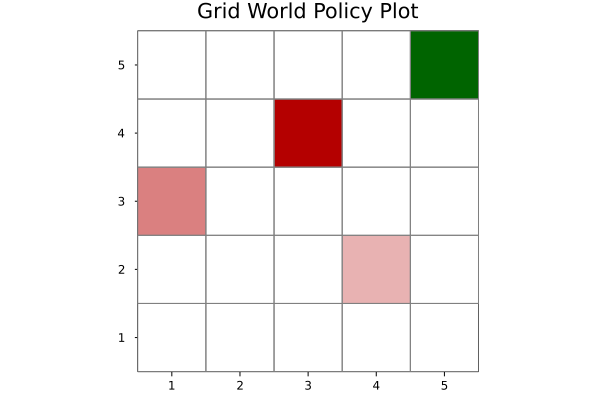

In [84]:
plot_grid_world(mdp)

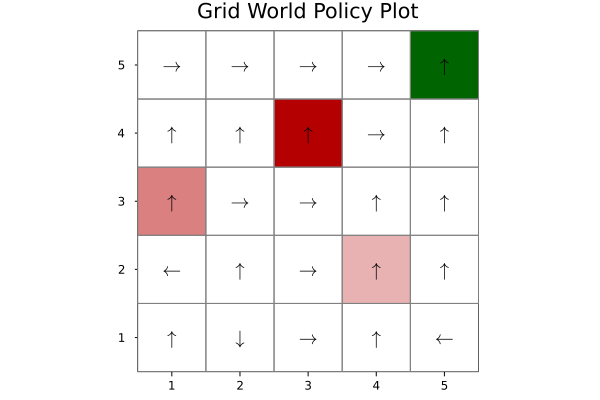

In [85]:
plot_grid_world(mdp, policy)

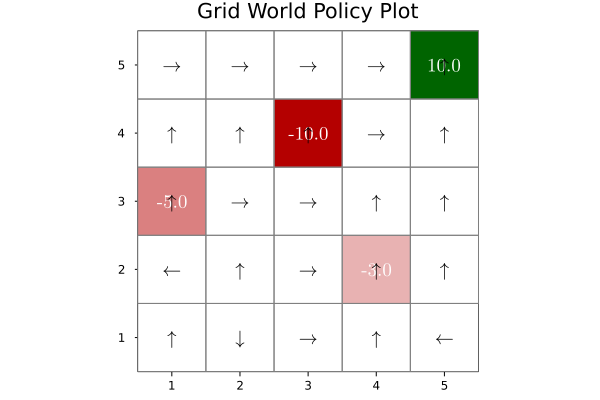

In [86]:
plot_grid_world(mdp, policy, show_rewards=true)

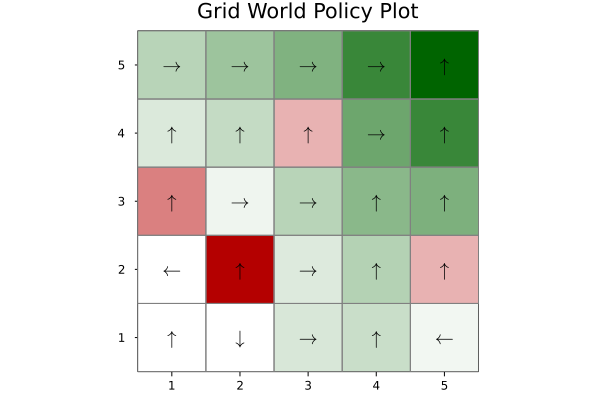

In [87]:
plot_grid_world(mdp, policy, 30)

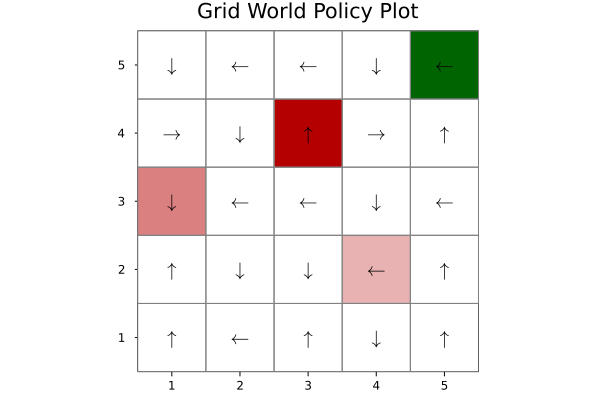

In [88]:
plot_grid_world(mdp, RandomPolicy(mdp))

## Distributions

Since MDPs are probabilistic models, we have to deal with probability distributions. In this section, we outline how to define probability distriubtions, and what tools are availiable to help you with the task.

### Transition Distribution 

If you are familiar with MDPs, you know that the transition function $T(s' \mid s, a)$ captures the dynamics of the system. Specifically, $T(s' \mid s, a)$ is a real value that defines the probabiltiy of transitioning to state $s'$ given that you took action $a$ in state $s$. The transition distirubtion $T(\cdot \mid s, a)$ is a slightly different construct. This is the actual distribution over the states that our agent can reach given that its in state $s$ and took action $a$. In other words this is the distribution over $s'$. 

For this grid world example there are only a few states that the agent can transition to, so there are only a few states that have nonzero probability in $T(\cdot \mid s, a)$. Thus, we will use the sparse [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) (`SparseCat`) from POMDPToolbox. [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) also contains some distributions, but in many cases, a custom distribution type will need to be defined - see [the source code for `SparseCat`](https://github.com/JuliaPOMDP/POMDPModelTools.jl/blob/master/src/distributions/sparse_cat.jl) for an example.

A `SparseCat` object contains a vector of states and an associated vector of their probabilities. The probabilities of all other states are implied to be zero.

## Transition Model

In this section we will define the system dynamics of the gird world MDP. In POMDPs.jl, we work with transition distirbution functions $T(s' \mid s, a)$, so we want to write a function that can generate the transition distributions over $s'$ for us given an $(s, a)$ pair. 

In grid world, the dynamics of the system are fairly simple. We move in the specified direction with some pre-defined probability. This is the `tprob` parameter in our GridWorld MDP (it is set to 0.7 in the DMU book example). If we get to state with a positive reward, we've reached a terminal state and can no longer accumulate reward.

In the transition function we want to fill the neighbors in our distribution d with the reachable states from the state, action pair. We want to fill the probs in our distirbution d with the probabilities of reaching that neighbor. 

In [89]:
# transition helpers
function inbounds(mdp::GridWorld,x::Int64,y::Int64)
    if 1 <= x <= mdp.size_x && 1 <= y <= mdp.size_y
        return true
    else
        return false
    end
end

inbounds(mdp::GridWorld, state::GridWorldState) = inbounds(mdp, state.x, state.y);

In [90]:
function POMDPs.transition(mdp::GridWorld, state::GridWorldState, action::Symbol)
    a = action
    x = state.x
    y = state.y
    
    if state.done
        return SparseCat([GridWorldState(x, y, true)], [1.0])
    elseif state in mdp.reward_states
        return SparseCat([GridWorldState(x, y, true)], [1.0])
    end

    neighbors = [
        GridWorldState(x+1, y, false), # right
        GridWorldState(x-1, y, false), # left
        GridWorldState(x, y-1, false), # down
        GridWorldState(x, y+1, false), # up
        ] # See Performance Note below
    
    targets = Dict(:right=>1, :left=>2, :down=>3, :up=>4) # See Performance Note below
    target = targets[a]
    
    probability = fill(0.0, 4)

    if !inbounds(mdp, neighbors[target])
        # If would transition out of bounds, stay in
        # same cell with probability 1
        return SparseCat([GridWorldState(x, y)], [1.0])
    else
        probability[target] = mdp.tprob

        oob_count = sum(!inbounds(mdp, n) for n in neighbors) # number of out of bounds neighbors

        new_probability = (1.0 - mdp.tprob)/(3-oob_count)

        for i = 1:4 # do not include neighbor 5
            if inbounds(mdp, neighbors[i]) && i != target
                probability[i] = new_probability
            end
        end
    end

    return SparseCat(neighbors, probability)
end;

In [91]:
function POMDPs.observation(mdp::GridWorld, state::GridWorldState)
    x = state.x
    y = state.y
    
    if state.done
        return SparseCat([GridWorldState(x, y, true)], [1.0])
    elseif state in mdp.reward_states
        return SparseCat([GridWorldState(x, y, true)], [1.0])
    end

    neighbors = [
        GridWorldState(x+1, y, false), # right
        GridWorldState(x-1, y, false), # left
        GridWorldState(x, y-1, false), # down
        GridWorldState(x, y+1, false), # up
        ] # See Performance Note below
    
    targets = Dict(:right=>1, :left=>2, :down=>3, :up=>4) # See Performance Note below
    target = targets[a]
    
    probability = fill(0.0, 4)

    if !inbounds(mdp, neighbors[target])
        # If would transition out of bounds, stay in
        # same cell with probability 1
        return SparseCat([GridWorldState(x, y)], [1.0])
    else
        probability[target] = mdp.oprob

        oob_count = sum(!inbounds(mdp, n) for n in neighbors) # number of out of bounds neighbors

        new_probability = (1.0 - mdp.oprob)/(3-oob_count)

        for i = 1:4 # do not include neighbor 5
            if inbounds(mdp, neighbors[i]) && i != target
                probability[i] = new_probability
            end
        end
    end

    return SparseCat(neighbors, probability)
end;

> Performance Note: It is inefficient to create mutable objects like dictionaries and vectors in low-level code like the `transition` function because it requires dynamic memory allocation. This code is written for clarity rather than speed. Better speed could be realized by putting the Dict in the mdp object or using if statements instead, and replacing the vector with a [`StaticArrays.Svector`](https://github.com/JuliaArrays/StaticArrays.jl). However, a much more important consideration for performance is [type stability](https://en.wikibooks.org/wiki/Introducing_Julia/Types#Type_stability), which this function maintains because it always returns a `SparseCat{Vector{GridWorldState},Vector{Float64}}` object.

## Miscallenous Functions
We are almost done! Just a few simple functions left. First let's implement implement the discount function.

In [92]:
POMDPs.discount(mdp::GridWorld) = mdp.discount_factor;

The last thing we need is indexing functions. This allows us to index between the discrete utility array and the states and actions in our problem. We will use the `CartesianIndices` and `LinearIndices` functions from Julia base to help us here.

In [93]:
function POMDPs.stateindex(mdp::GridWorld, state::GridWorldState)
    sd = Int(state.done + 1)
    ci = CartesianIndices((mdp.size_x, mdp.size_y, 2))
    return LinearIndices(ci)[state.x, state.y, sd]
end

function POMDPs.actionindex(mdp::GridWorld, act::Symbol)
    if act==:up
        return 1
    elseif act==:down
        return 2
    elseif act==:left
        return 3
    elseif act==:right
        return 4
    end
    error("Invalid GridWorld action: $act")
end;

Finally let's define a function that checks if a state is terminal.

In [94]:
POMDPs.isterminal(mdp::GridWorld, s::GridWorldState) = s.done

In [95]:
POMDPs.initialstate(pomdp::GridWorld) = Deterministic(GridWorldState(1,1)) # TODO: define initialistate for states, not distributions?

# Simulations

Now that we have defined the problem, we should simulate it to see it working. The funcion `stepthrough` from `POMDPSimulators` provides a convenient `for` loop syntax for exploring the behavior of the mdp. The `POMDPPolicies` provides a way for defining simple policies, such as `RandomPolicy` or `FunctionPolicy` that takes a lambda function to determine the next action based on the state `s`.

In [96]:
mdp = GridWorld()
mdp.tprob=1.0

policy = RandomPolicy(mdp)
left_policy = FunctionPolicy(s->:left)
right_policy = FunctionPolicy(s->:right)

for (s,a,r) in stepthrough(mdp, policy, "s,a,r", max_steps=10)
    @show s
    @show a
    @show r
    println()
end

s = GridWorldState(1, 1, false)
a = :right
r = 0.0

s = GridWorldState(2, 1, false)
a = :down
r = 0.0

s = GridWorldState(2, 1, false)
a = :up
r = 0.0

s = GridWorldState(2, 2, false)
a = :down
r = 0.0

s = GridWorldState(2, 1, false)
a = :left
r = 0.0

s = GridWorldState(1, 1, false)
a = :down
r = 0.0

s = GridWorldState(1, 1, false)
a = :right
r = 0.0

s = GridWorldState(2, 1, false)
a = :right
r = 0.0

s = GridWorldState(3, 1, false)
a = :down
r = 0.0

s = GridWorldState(3, 1, false)
a = :right
r = 0.0



## Value Iteration Solver

Value iteration is a dynamic porgramming apporach for solving MDPs. See the [wikipedia](https://en.wikipedia.org/wiki/Markov_decision_process#Value_iteration) article for a brief explanation. The solver can be found [here](https://github.com/JuliaPOMDP/DiscreteValueIteration.jl). If you haven't isntalled the solver yet, you can run the following from the Julia REPL to download the module.

```julia
POMDPs.add("DiscreteValueIteration")
```

Each POMDPs.jl solver provides two data types for you to interface with. The first is the Solver type which contains solver parameters. The second is the Policy type. Let's see hwo we can use them to get an optimal action at a given state.

In [97]:
# first let's load the value iteration module
using DiscreteValueIteration

# initialize the problem
mdp = GridWorld()

# initialize the solver
# max_iterations: maximum number of iterations value iteration runs for (default is 100)
# belres: the value of Bellman residual used in the solver (defualt is 1e-3)
solver = ValueIterationSolver(max_iterations=100, belres=1e-3; verbose=true)

# solve for an optimal policy
policy = solve(solver, mdp); 

[Iteration 1   ] residual:         10 | iteration runtime:      0.047 ms, (  4.73E-05 s total)
[Iteration 2   ] residual:       6.17 | iteration runtime:      0.039 ms, (  8.67E-05 s total)
[Iteration 3   ] residual:       4.44 | iteration runtime:      0.035 ms, (  0.000122 s total)
[Iteration 4   ] residual:       2.81 | iteration runtime:      0.034 ms, (  0.000156 s total)
[Iteration 5   ] residual:       1.73 | iteration runtime:      0.030 ms, (  0.000186 s total)
[Iteration 6   ] residual:      0.781 | iteration runtime:      0.034 ms, (  0.000219 s total)
[Iteration 7   ] residual:      0.548 | iteration runtime:      0.031 ms, (  0.000251 s total)
[Iteration 8   ] residual:      0.411 | iteration runtime:      0.029 ms, (   0.00028 s total)
[Iteration 9   ] residual:      0.325 | iteration runtime:      0.035 ms, (  0.000314 s total)
[Iteration 10  ] residual:      0.234 | iteration runtime:      0.029 ms, (  0.000343 s total)
[Iteration 11  ] residual:      0.147 | iteration 

Now, we can use the policy along with the ```action(...)``` function to get the optimal action in a given state.

In [98]:
# say we are in state (9,2)
s = GridWorldState(9,2)
a = action(policy, s)

LoadError: BoundsError: attempt to access 5×5×2 LinearIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}} at index [9, 2, 1]

Remeber that the state (9,3) has an immediate reward of +10.0, so the policy we found is moving up as expected!

In [99]:
s = GridWorldState(8,3)
a = action(policy, s)

LoadError: BoundsError: attempt to access 5×5×2 LinearIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}} at index [8, 3, 1]

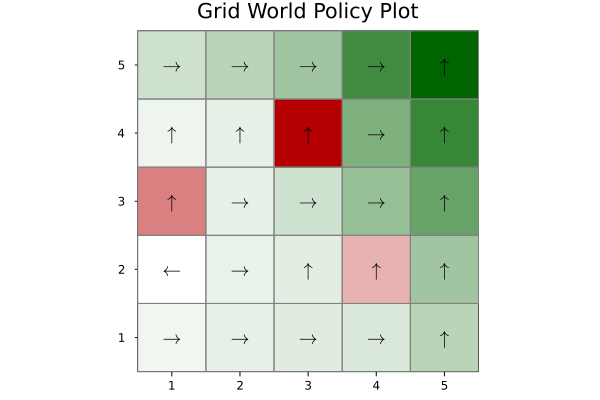

In [100]:
plot_grid_world(mdp, policy, 30)

To see the path an agent may take in the gridworld, starting in the initial state (set to `(1,1)`), you may run following code. Note that the policy differs from the example above, as the gridworld in the image has -1 reward for accidentaly trying to move into the wall, which we have not implemented in our MDP.

In [101]:
for (s,a,r) in stepthrough(mdp, policy, "s,a,r", max_steps=20)
    @show s
    @show a
    @show r
    println()
end

s = GridWorldState(1, 1, false)
a = :right
r = 0.0

s = GridWorldState(2, 1, false)
a = :right
r = 0.0

s = GridWorldState(3, 1, false)
a = :right
r = 0.0

s = GridWorldState(3, 2, false)
a = :up
r = 0.0

s = GridWorldState(3, 3, false)
a = :right
r = 0.0

s = GridWorldState(2, 3, false)
a = :right
r = 0.0

s = GridWorldState(3, 3, false)
a = :right
r = 0.0

s = GridWorldState(3, 2, false)
a = :up
r = 0.0

s = GridWorldState(3, 3, false)
a = :right
r = 0.0

s = GridWorldState(4, 3, false)
a = :right
r = 0.0

s = GridWorldState(5, 3, false)
a = :up
r = 0.0

s = GridWorldState(5, 2, false)
a = :up
r = 0.0

s = GridWorldState(5, 1, false)
a = :up
r = 0.0

s = GridWorldState(5, 2, false)
a = :up
r = 0.0

s = GridWorldState(4, 2, false)
a = :up
r = -3.0



# Trying Different Transition Probabilities Observation Model

In [106]:
mdp = GridWorld()
mdp.tprob=0.7

solver = ValueIterationSolver(max_iterations=100, belres=1e-3; verbose=true)

# solve for an optimal policy
policy = solve(solver, mdp); 

# plot policy and values of each state
plot_grid_world(mdp, policy, 30, show_rewards=true)


[Iteration 1   ] residual:         10 | iteration runtime:      0.128 ms, (  0.000128 s total)
[Iteration 2   ] residual:       6.17 | iteration runtime:      0.076 ms, (  0.000205 s total)
[Iteration 3   ] residual:       4.44 | iteration runtime:      0.082 ms, (  0.000287 s total)
[Iteration 4   ] residual:       2.81 | iteration runtime:      0.077 ms, (  0.000365 s total)
[Iteration 5   ] residual:       1.73 | iteration runtime:      0.075 ms, (   0.00044 s total)
[Iteration 6   ] residual:      0.781 | iteration runtime:      0.080 ms, (   0.00052 s total)
[Iteration 7   ] residual:      0.548 | iteration runtime:      0.081 ms, (    0.0006 s total)
[Iteration 8   ] residual:      0.411 | iteration runtime:      0.073 ms, (  0.000673 s total)
[Iteration 9   ] residual:      0.325 | iteration runtime:      0.069 ms, (  0.000743 s total)
[Iteration 10  ] residual:      0.234 | iteration runtime:      0.070 ms, (  0.000813 s total)
[Iteration 11  ] residual:      0.147 | iteration 

LoadError: MethodError: no method matching getindex(::ValueIterationPolicy{Matrix{Float64}, Vector{Float64}, Vector{Int64}, Symbol, GridWorld}, ::GridWorldState)

In [114]:
pomdp = GridWorld()
pomdp.tprob = 0.8
@show pomdp

n_simulations = 15000

solver = ValueIterationSolver(verbose=false)
@show solver
policy = solve(solver, pomdp)

vec = zeros(length(states(pomdp)))
vec[1] = 1.0

r_total = zeros(n_simulations)

for sim in 1:n_simulations
    s = GridWorldState(1, 1, false)
    r = 0
    for iter in 1:15
        a = action(policy, s)
        s = rand(transition(pomdp, s, a))
        r += pomdp.discount_factor^(iter) * reward(pomdp, s, a)
        if s.done
            break
        end
    end
    r_total[sim] = r
end

mean(r_total)

pomdp = GridWorld(5, 5, GridWorldState[GridWorldState(5, 5, false), GridWorldState(3, 4, false), GridWorldState(1, 3, false), GridWorldState(4, 2, false)], [10.0, -10.0, -5.0, -3.0], 0.8, 0.9)
solver = ValueIterationSolver(100, 0.001, false, true, Float64[])


1.8356402318415188

In [123]:
plot_grid_world(mdp, policy, 30)
policy

ValueIterationPolicy:
 GridWorldState(1, 1, false) -> :right
 GridWorldState(2, 1, false) -> :right
 GridWorldState(3, 1, false) -> :right
 GridWorldState(4, 1, false) -> :right
 GridWorldState(5, 1, false) -> :up
 GridWorldState(1, 2, false) -> :right
 GridWorldState(2, 2, false) -> :right
 GridWorldState(3, 2, false) -> :up
 GridWorldState(4, 2, false) -> :up
 GridWorldState(5, 2, false) -> :up
 GridWorldState(1, 3, false) -> :up
 GridWorldState(2, 3, false) -> :right
 GridWorldState(3, 3, false) -> :right
 GridWorldState(4, 3, false) -> :right
 GridWorldState(5, 3, false) -> :up
 GridWorldState(1, 4, false) -> :up
 GridWorldState(2, 4, false) -> :up
 GridWorldState(3, 4, false) -> :up
 GridWorldState(4, 4, false) -> :right
 GridWorldState(5, 4, false) -> :up
 GridWorldState(1, 5, false) -> :right
 GridWorldState(2, 5, false) -> :right
 GridWorldState(3, 5, false) -> :right
 GridWorldState(4, 5, false) -> :right
 GridWorldState(5, 5, false) -> :up
 …

In [104]:
history = HistoryRecorder(max_steps=1000)
for i in 1:1000
    hist = simulate(history, mdp, policy, GridWorldState(1,1))
    @show discounted_reward(hist)
    @show total_reward(hist)
end

discounted_reward(hist) = 0.0


LoadError: UndefVarError: total_reward not defined

## Monte-Carlo Tree Search Solver
Monte-Carlo Tree Search (MCTS) is another MDP solver. It is an online method that looks for the best action from only the current state by building a search tree. A nice overview of MCTS can be found [here](http://www.diego-perez.net/papers/MCTSSurvey.pdf). Run the following command to donwload the module



```julia
POMDPs.add("MCTS")
```

Let's quickly run through an example of using the solver:

In [31]:
using MCTS

# initialize the problem
mdp = GridWorld()

# initialize the solver with hyper parameters
# n_iterations: the number of iterations that each search runs for
# depth: the depth of the tree (how far away from the current state the algorithm explores)
# exploration constant: this is how much weight to put into exploratory actions. 
# A good rule of thumb is to set the exploration constant to what you expect the upper bound on your average expected reward to be.
solver = MCTSSolver(n_iterations=1000,
                    depth=20,
                    exploration_constant=10.0,
                    enable_tree_vis=true)

# initialize the planner by calling the `solve` function. For online solvers, the 
planner = solve(solver, mdp)

# to get the action:
s = GridWorldState(9,2)
a = action(planner, s)

:left

Let's simulate using the planner to determine a good action at each timestep.

In [25]:
s = GridWorldState(4,1) # this is our starting state
hist = HistoryRecorder(max_steps=1000)

hist = simulate(hist, mdp, policy, s)

println("Total discounted reward: $(discounted_reward(hist))")

Total discounted reward: 0.8862938119652508


Now we can view the state-action history using the `eachstep` function.

In [33]:
using Printf
for (s, a, sp) in eachstep(hist, "s,a,sp")
    @printf("s: %-26s  a: %-6s  s': %-26s\n", s, a, sp)
end

s: GridWorldState(4, 1, false)  a: up      s': GridWorldState(4, 2, false)
s: GridWorldState(4, 2, false)  a: left    s': GridWorldState(3, 2, false)
s: GridWorldState(3, 2, false)  a: left    s': GridWorldState(2, 2, false)
s: GridWorldState(2, 2, false)  a: up      s': GridWorldState(2, 2, true)


To see what the planner is doing, we can look at the tree created when it plans at a particular state, for example, the first state in the history.

In [34]:
using D3Trees

# first, run the planner on the state
s = state_hist(hist)[1]
a, info = action_info(planner, s);

# show the tree (click the node to expand)
D3Tree(info[:tree], init_expand=1)

LoadError: ArgumentError: Package D3Trees not found in current path:
- Run `import Pkg; Pkg.add("D3Trees")` to install the D3Trees package.
